# Word2Vec: Pytorch Implementation

## Preface: On Embeddings

The utility of embedding methods is linked to the original challenges motivating text-as-data methods. Byrepresenting natural language numerically, embedding methods offer the possibility to leverage a broad range of quantitative tools on hitherto unusable sources of data. 

At a high level, word embeddings represent the individual words (vocabulary) of a collection of texts (corpus) as vectors in a k-dimensional space. These vectors encode information about the relationbship between words and their context, and are used for downstream language modelling tasks.

## Step 1: Loading the data

As with any NLP task (in general), there are two main steps to be followed:
 * Preparing the data (the loading)
 * Processing the data (model)

In [1]:
!pip install torch
!pip install nltk
!pip install datasets
import torch
import datasets

dataset = datasets.load_dataset('tweets_hate_speech_detection')

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (/home/shubhankar/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

We need a function to split up the raw tweets into lists of tokens. For this, the preprocessing itself is kept very simple, and apply:
1. Lowercase all
2. Remove all symbols other than a-z@#
3. Split on spaces.
4. Remove stopwords/empty tokens.
5. Apply snowball stemmer to remainder

In [2]:
# We'll remove alphanumeric but keep @,#
import re
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

ss = SnowballStemmer('english')
sw = stopwords.words('english')

def split_tokens(row):
    row['all_tokens'] = [ss.stem(i) for i in 
                      re.split(r" +", 
                      re.sub(r"[^a-z@# ]", "",
                            row['tweet'].lower()))
                      if (i not in sw) and len(i)]
    return row

#Determine vocabulary so we can create mapping
dataset = dataset.map(split_tokens) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shubhankar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Loading cached processed dataset at /home/shubhankar/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2/cache-1881b7d4fd39d6eb.arrow


From these we can construct some useful variables for the future. But first let's remove tokens that occur fewer than 10 times to reduce the size of our vocabulary.
* ```counts```: Total word counts
* ```vocab```: Unique tokens in corpus
* ```n_v```: Size of vocabulary
* ```id2tok/tok2id```: Move back and forth between tokens and numeric ids

In [3]:
from collections import Counter

counts = Counter([i for s in dataset['train']['all_tokens'] for i in s])
counts = {k:v for k,v in counts.items() if v>10} #filtering
vocab = list(counts.keys())
n_v = len(vocab) 
id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

# Now correct tokens 
def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

dataset = dataset.map(remove_rare_tokens)

Loading cached processed dataset at /home/shubhankar/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2/cache-fccb5fdd1de69816.arrow


Now finally we need to prepare the "sliding window" used in the word2vec algorithm. The target sentence is converted into pairs of ```target```, ```context``` where context is a list of the tokens within the window.

In [4]:
def windowizer(row, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window
    pairs.
    """
    doc = row['tokens']
    wsize = 3
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [i+j for j in
                  range(-wsize, wsize+1, 1)
                  if (i+j>=0) &
                     (i+j<len(doc)) &
                     (j!=0)]

        out+=[(target, tok2id[doc[w]]) for w in window]
    row['moving_window'] = out
    return row

dataset = dataset.map(windowizer)


Loading cached processed dataset at /home/shubhankar/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2/cache-9193f44e52fe397b.arrow


Now we build this into a PyTorch Dataset class so that we can pass it to a DataLoader class.

The main advantages of using a DataLoader is the ability to efficiently manage VRAM usage and transfer between disk/RAM/VRAM. It also allows for multiprocessing on the loading/preprocessing side, which can provide speed-ups.

The ```Dataset``` class requires the following 3 methods:

* ```__init__```: This gets executed when the class in instantiated. Typically, here is where you define attributes, such as an underlying data object or a preprocessing step that you don't want to execute on-the-fly.
* ```__len__```: This should return the length of the dataset. I assume it's important for knowing how much memory to allocate.
* ```__getitem__```: Given an index, return the element of the dataset corresponding to the given index. 

What's happening here is:
* We are building a single tensor to hold all (word, context-word) pairs, which we'll randomly sample from.
* Returning the (word, context-word) pair.

In [5]:
from torch.utils.data import Dataset, DataLoader

class Word2VecDataset(Dataset):
    # Takes a dataset as input to be used for a Word2Vec dataloader
    def __init__(self, dataset, vocab_size, wssize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

And now we wrap the dataset with a DataLoader. Note that at this point I'm defining two "global" variables (in all caps): ```BATCH_SIZE``` and ```N_LOADER_PROCS```.

```BATCH_SIZE``` is the number of observations returned with each call. Much of the speed-ups from GPU processing come from massive batched matrix computations. When choosing batch size, remember that it's generally at trade-off between VRAM usage and speed, except for when the the dataloader itself is the bottle. To speed up the dataloader, we can pass an argument to ```num_workers``` to enable parallelisation on the data preparation and loading.

In [6]:
BATCH_SIZE = 2**14
N_LOADER_PROCS = 10 

dataloader = {}
for key in dataset.keys():
    dataloader = {key: DataLoader(Word2VecDataset(
                                    dataset[key], vocab_size=n_v),
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=N_LOADER_PROCS)}

# Step 2: Building the Network

Now that we've defined our loader, we can define our neural network. The way we build NNs in PyTorch may seem strange at first, but it quickly becomes natural. We use the same Python class structure to instantiate the "building blocks" in the ```__init__```, and then define the "forward pass" (i.e. the path from the input to the output) in the ```forward``` method. 

```Word2Vec``` architecture as defined by Mikolov:
* 3 layers : input, hidden and output layer
* Input and output are the size of the vocabulary. Hidden is smaller than either.
* Fully connected with linear activations.

There are 2 variants of this architecture:
* ```CBOW``` (continuous bag-of-words): context word is input, center word is output.
* ```skip-gram```: center word is input, context word is output.

## Aside: Manually implementing one-hot encoding



In [7]:
from torch import nn

size=10
input=3

def one_hot_encode(input, size):
    vec = torch.zeros(size).float()
    vec[input] = 1.0
    return vec

ohe = one_hot_encode(input, size)
linear_layer = nn.Linear(size, 1, bias=False)

#Set edge weights from 0 to 9 for easy reference
with torch.no_grad():
    linear_layer.weight = nn.Parameter(
        torch.arange(10, dtype=torch.float).reshape(linear_layer.weight.shape))

print(linear_layer.weight)
print(linear_layer(ohe))

Parameter containing:
tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]], requires_grad=True)
tensor([3.], grad_fn=<SqueezeBackward3>)


### Wut?

1. Firstly, we created a tensor of zeros equal in size to the vocabulary, and then assign ```1``` to the value corresponding to our feature.
2. We instantiate a linear layer with no bias, which is essentially a 10x1 tensor of edge weights.
3. I overwrite the randomly initialized weights with the values 0-9. We wrap this in ```torch.no_grad``` to disable gradient tracking; in short, operations on PyTorch tensors with gradient descent tracking enabled are stored in order to differentiate the loss w.r.t. every parameter in the model. Because here I am manually setting the parameters, I don’t actually want this action to be stored and considered when making a future backprop calculation.
4. When we pass our OH encoded vector, we retrieve the weight corresponding to the input id.


In [8]:
embedding_layer = nn.Embedding(size, 1)

with torch.no_grad():
    embedding_layer.weight = nn.Parameter(
        torch.arange(10, dtype=torch.float
                     ).reshape(embedding_layer.weight.shape))

print(embedding_layer.weight)
print(embedding_layer(torch.tensor(input)))


Parameter containing:
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]], requires_grad=True)
tensor([3.], grad_fn=<EmbeddingBackward0>)


## Implementation of Word2Vec

In [9]:
class Word2Vec(nn.Module): # we define our neural network as a child class of nn.Module, meaning we inherit all the methods of the parent class nn.Module. Note also that we are not building the network here, but a blueprint to instantiate the network.
    def __init__(self, vocab_size, embedding_size):
        super().__init__() # instantiates all of the init methods of the parent class
        self.embed = nn.Embedding(vocab_size, embedding_size) # an embedding layer to convert the input (the index of the center/context token) into the the one-hot encoding, and then retrieve the weights corresponding to these indices in the lower-dimensional hidden layer
        self.expand = nn.Linear(embedding_size, vocab_size, bias = False) # a linear layer to predict the probability of a center/context word given the hidden layer. We disable bias (the intercept) because we rescale our predictions anyways.
        

    def forward(self, input): # forward(): defining the forward pass
        # Encode input to lower-dimensional representation
        hidden = self.embed(input)
        # Expand hidden layer to prediction
        logits = self.expand(hidden) # re-expanding the hidden layer to make predictions. These raw predictions need to be re-scaled using softmax, but we skip this step here as PyTorch implements the relevant steps under Cross Entropy loss
        return logits

# Step 3: Training the model

Unlike the usual ML or statistical models, when training neural network there's not a clear point at which the model has "finished" training. 

Training in the context of neural networks means repeatedly making predictions using the observations in the dataset and then adjusting the parameters accordingly to correct for the error in predictions. Because we don't want the network to perfectly learn the most recent prediction while forgetting all other predictions, we usually give it a "learning rate", which is some penalty on the loss adjustment to prevent fitting only to the most recent observation. 

The longer we train the network, the more perfectly it will learn the training data, but this often comes with the risk of overfitting and failing to generalise to unseen data. However, given that with Word2Vec is not to infer unseen data, but to descrie "seen" data.

Though I'm not exactly sure what the implications of overfitting in this context are, it might have something to do with the global and domain-specific (or corpus-specific) meanings of the said word.

A simple for-loop is used for the training. 

In [10]:
# Instantiate the model
EMBED_SIZE = 100 # Quite small, just for the tutorial
model = Word2Vec(n_v, EMBED_SIZE)

# Time to use those GPUs lol :) [But in case you don't DO NOT USE THIS IF YOU DON'T WANT TO BREAK YOUR PC]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device) # huehuehuehuehue

# Define training parameters
LR = 3e-4  # learning rate
EPOCHS = 10 # number of times to pass the full training data through the model
loss_fn = nn.CrossEntropyLoss() # in short, the appropriate loss function for making categorical predictions
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) # the algorithm on how to update the parameters as a function of loss

Running 10 epochs of the loop:

In [11]:
from tqdm import tqdm  # For progress bars

progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)


100%|█████████▉| 529/530 [00:21<00:00, 37.46it/s]

Plotting the running loss:

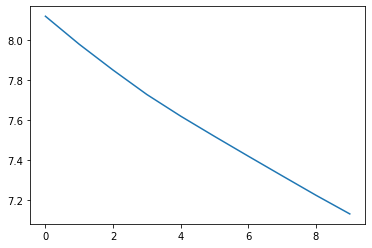

In [12]:
import matplotlib.pyplot as plt
plt.plot(running_loss)


As we continue the training process, the marginal increase in accuracy overall starts to slow down. But, in this case (with embedding models), accuracy is not the main goal of the model. 

The embeddings are the edge weights between the hidden layer and the output.

In [13]:
wordvecs = model.expand.weight.cpu().detach().numpy()
tokens = ['good', 'father', 'school', 'hate']


Now, we get the closests vectors:

In [14]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

good ['go', 'like', 'best', 'amp', '@user', 'make', 'one', 'come', 'feel', 'get'] 

father ['day', 'anoth', 'dad', '#fathersday', 'happi', 'everyon', '#love', 'one', 'today', 'amp'] 

school ['enjoy', 'amp', 'night', 'one', 'two', 'day', 'get', 'new', 'next', 'sta'] 

hate ['go', 'call', '@user', 'could', 'new', 'happi', 'enjoy', 'cant', 'talk', 'like'] 



We further train the model for 90 more epochs and see how these change:

In [15]:
EPOCHS = 90
progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)


100%|██████████| 530/530 [00:22<00:00, 23.38it/s]


Extracting new word vectors:

In [20]:
wordvecs_100_epochs = model.expand.weight.cpu().detach().numpy()
dmat_100_epochs = get_distance_matrix(wordvecs_100_epochs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat_100_epochs)], "\n")


good ['@user', 'im', 'today', 'great', 'amp', 'go', 'make', 'one', 'day', 'happi'] 

father ['dad', 'day', '#fathersday', 'wish', 'love', 'happi', 'one', 'god', 'enjoy', 'bihday'] 

school ['year', 'tomorrow', 'first', 'new', 'week', 'month', 'two', 'today', 'back', 'last'] 

hate ['kill', 'peopl', 'call', 'dont', 'say', 'still', 'mani', 'would', 'even', 'much'] 



Saving the model:

In [21]:
torch.save(model.state_dict(), 'word2vec-twitter_hate-100epochs.checkpoint')